# A model for predicting incremental diameter growth

Here we will adapt the basic diameter growth model for large trees from the Forest Vegetation Simulator into a aggregates monthly predictions of diameter growth over arbitrary periods of one or more months. 

In [1]:
from matplotlib import pyplot as plt
import numpy as np

from jax import numpy as jnp

from jax import random, jit
from jax.lax import scan
from functools import partial

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import arviz as az

import pandas as pd
# from concurrent.futures import ProcessPoolExecutor, as_completed
# from tqdm.notebook import tqdm
# import warnings

In [2]:
numpyro.set_platform("cpu")
numpyro.set_host_device_count(3)

In [3]:
# def scan(f, init, xs, length=None):
#     if xs is None:
#       xs = [None] * length
#     carry = init
#     ys = []
#     for x in xs:
#       carry, y = f(carry, x)
#       ys.append(y)
#     return carry, np.stack(ys)

In [4]:
def grow_step(dbh, covars, coefs):
    b0, b1, b2, b3, b4, b5, b6, b7, b8, b9, b10, b11, b12, b13, bark_b1, bark_b2 = coefs
    location, site_index, asp, slope, elev, crown_ratio, comp_tree, comp_stand = covars
    size = b1 * jnp.log(dbh) + b2 * (dbh**2)
    site = b3 * jnp.log(site_index) + \
           b4 * (slope * jnp.cos(asp)) + b5 * (slope * jnp.sin(asp)) + \
           b6 * slope + b7 * slope**2 + \
           b8 * elev + b9 * elev ** 2
    comp = b10 * crown_ratio + b11 * crown_ratio**2 + \
           b12 * comp_tree + b13 * comp_stand
    ln_dds = b0 + size + site + comp
    
    dds = jnp.exp(ln_dds)
    
    dib_start = bark_b1*(dbh**bark_b2)
    dg_ib = jnp.sqrt(dib_start**2 + dds) - dib_start
    dib_end = dib_start + dg_ib
    dbh_end = (dib_end / bark_b1)**(1/bark_b2)
    dg_ob = dbh_end - dbh
    
    return dbh_end, dg_ob

def grow(dbh, covars, coefs):
    partial_grow = partial(grow_step, coefs=coefs)
    end_dbh, dgs = scan(partial_grow, init=dbh, xs=covars)
    return end_dbh, dgs    

In [5]:
def grow(dbh, location, site_index, asp, slope, elev, cr_start, cr_end, 
         comp_tree_start, comp_tree_end, comp_stand_start, comp_stand_end, 
         num_steps, 
         obs_dg=None):
    
    dbh = jnp.atleast_1d(dbh)
    num_trees = dbh.size
    location = jnp.atleast_1d(location)
    site_index = jnp.atleast_1d(site_index)
    asp = jnp.atleast_1d(asp)
    slope = jnp.atleast_1d(slope)
    elev = jnp.atleast_1d(elev)

    b0 = 0
    b1 = 0.802905 # ln(dbh)
    b2 = -0.0000896 # dbh**2
    b3 = 0.495162 # ln(site_index)
    b4 = 0.014165 # slope*cos(asp)
    b5 = 0.003263 # slope*sin(asp)
    b6 = 0.340401 # slope
    b7 = 0  # slope**2
    b8 = -0.009845 # elev
    b9 = 0 # elev**2
    b10 = 1.9369120  # crown_ratio
    b11 = 0 # crown_ratio**2
    b12 = -0.001827  # comp_tree  # BAL / ln(dbh+1)
    b13 = -0.12947  # comp_stand  # ln(BA)
    bark_b1 = 0.903563
    bark_b2 = 0.989388
    
    location = jnp.full((num_steps, num_trees), location)
    site_index = jnp.full((num_steps, num_trees), site_index)
    asp = jnp.full((num_steps, num_trees), site_index) 
    slope = jnp.full((num_steps, num_trees), slope)
    elev = jnp.full((num_steps, num_trees), elev)
    crown_ratio = jnp.linspace(cr_start, cr_end, num_steps)
    comp_tree = jnp.linspace(comp_tree_start, comp_tree_end, num_steps)
    comp_stand = jnp.linspace(comp_stand_start, comp_stand_end, num_steps)

    covars = location, site_index, asp, slope, elev, crown_ratio, comp_tree, comp_stand

    def step(dbh, covars):
        location, site_index, asp, slope, elev, crown_ratio, comp_tree, comp_stand = covars

        size = b1 * jnp.log(dbh) + b2 * (dbh**2)
        site = b3 * jnp.log(site_index) + \
              b4 * (slope * jnp.cos(asp)) + b5 * (slope * jnp.sin(asp)) + \
              b6 * slope + b7 * slope**2 + \
              b8 * elev + b9 * elev ** 2
        comp = b10 * crown_ratio + b11 * crown_ratio**2 + \
              b12 * comp_tree + b13 * comp_stand
        ln_dds = b0 + size + site + comp

        dds = jnp.exp(ln_dds)

        dib_start = bark_b1*(dbh**bark_b2)
        dg_ib = jnp.sqrt(dib_start**2 + dds) - dib_start
        dib_end = dib_start + dg_ib
        dbh_end = (dib_end / bark_b1)**(1/bark_b2)
        dg_ob = dbh_end - dbh

        return dbh_end, dg_ob
    
    # scan returns arrays of final dbh (shape: (n_trees,)) 
    # and of incremental growth (shape: (n_steps, n_trees))
    end_dbhs, growth = scan(step, dbh, covars, length=num_steps)       
    return growth

In [6]:
DBH = 10.
LOCATION = 0
SITE_INDEX = 105
ASP = 0
SLOPE = 0
ELEV = 10
CR_START = 1.0
CR_END = 0.2
COMP_TREE_START = 5
COMP_TREE_END = 5
COMP_STAND_START = 5
COMP_STAND_END = 5
NUM_STEPS = 20

result = grow(DBH, LOCATION, SITE_INDEX, ASP, SLOPE, ELEV, 
              CR_START, CR_END, COMP_TREE_START, COMP_TREE_END, COMP_STAND_START, COMP_STAND_END,
              num_steps=NUM_STEPS)

result.shape, result

((20, 1),
 DeviceArray([[9.225378 ],
              [8.7691345],
              [7.83996  ],
              [6.8757286],
              [5.992317 ],
              [5.2175827],
              [4.550434 ],
              [3.9800262],
              [3.493103 ],
              [3.0768433],
              [2.7199097],
              [2.4126282],
              [2.1469803],
              [1.9163132],
              [1.715126 ],
              [1.5389786],
              [1.3841019],
              [1.2474365],
              [1.1264343],
              [1.0189514]], dtype=float32))

In [7]:
DBH = 1.
LOCATION = 0
SITE_INDEX = 105
ASP = 0
SLOPE = 0
ELEV = 10
CR_START = 1.0
CR_END = 0.2
COMP_TREE_START = 5
COMP_TREE_END = 5
COMP_STAND_START = 5
COMP_STAND_END = 5
NUM_STEPS = 20

result = grow(DBH, LOCATION, SITE_INDEX, ASP, SLOPE, ELEV, 
              CR_START, CR_END, COMP_TREE_START, COMP_TREE_END, COMP_STAND_START, COMP_STAND_END,
              num_steps=NUM_STEPS)

result.shape, result

((20, 1),
 DeviceArray([[5.5328608],
              [8.2654   ],
              [8.246295 ],
              [7.5023117],
              [6.649372 ],
              [5.8420486],
              [5.120739 ],
              [4.4910316],
              [3.9466705],
              [3.4776917],
              [3.0736504],
              [2.7248993],
              [2.4229813],
              [2.1607132],
              [1.932045 ],
              [1.7319183],
              [1.5561371],
              [1.4011765],
              [1.264122 ],
              [1.1425095]], dtype=float32))

In [8]:
DBH = jnp.array([0.1, 10.0])
LOCATION = jnp.array([0, 1])
SITE_INDEX = jnp.array([105, 105])
ASP = jnp.array([0, 0])
SLOPE = jnp.array([0, 0])
ELEV = jnp.array([10, 10])
CR_START = jnp.array([1.0, 1.0])
CR_END = jnp.array([0.2, 0.2])
COMP_TREE_START = jnp.array([5, 5])
COMP_TREE_END = jnp.array([5, 5])
COMP_STAND_START = jnp.array([5, 5])
COMP_STAND_END = jnp.array([5, 5])
NUM_STEPS = 20

result = grow(DBH, LOCATION, SITE_INDEX, ASP, SLOPE, ELEV, 
              CR_START, CR_END, COMP_TREE_START, COMP_TREE_END, COMP_STAND_START, COMP_STAND_END,
              num_steps=NUM_STEPS)

result.shape, result

((20, 2),
 DeviceArray([[2.4369514, 9.225378 ],
              [6.856844 , 8.7691345],
              [8.096249 , 7.83996  ],
              [7.6712112, 6.8757286],
              [6.896076 , 5.992317 ],
              [6.099304 , 5.2175827],
              [5.3657875, 4.550434 ],
              [4.7159004, 3.9800262],
              [4.1493073, 3.493103 ],
              [3.658619 , 3.0768433],
              [3.2344627, 2.7199097],
              [2.8675804, 2.4126282],
              [2.5495758, 2.1469803],
              [2.273117 , 1.9163132],
              [2.0319977, 1.7151413],
              [1.8209534, 1.5389786],
              [1.635582 , 1.3841019],
              [1.4722366, 1.2474365],
              [1.3277893, 1.1264267],
              [1.1996994, 1.0189438]], dtype=float32))

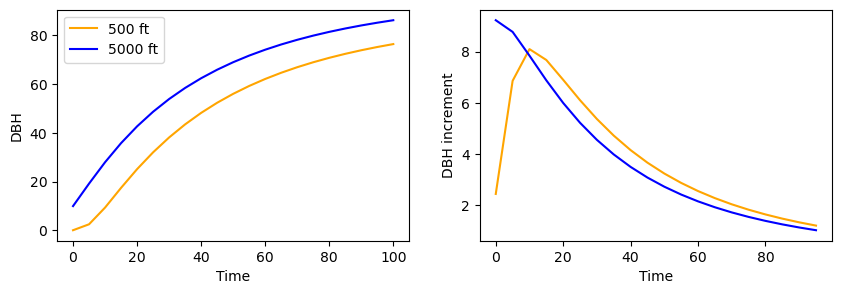

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10,3))

results = np.insert(np.cumsum(result.T, axis=1).T + DBH, 0, DBH, axis=0).T
years = np.arange(0, (NUM_STEPS+1)*5, 5)
ax[0].plot(years, results[0], color='orange', label='500 ft')
ax[0].plot(years, results[1], color='blue', label='5000 ft')
ax[0].set(xlabel='Time', ylabel='DBH')
ax[0].legend()
ax[1].plot(years[:-1], np.diff(results[0]), color='orange')
ax[1].plot(years[:-1], np.diff(results[1]), color='blue')
ax[1].set(xlabel='Time', ylabel='DBH increment')
plt.show()

In [10]:
CSV = '../data/interim/FIA_remeasured_trees_for_training.csv'
df = pd.read_csv(CSV)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290429 entries, 0 to 290428
Data columns (total 63 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   STATECD            290429 non-null  int64  
 1   UNITCD             290429 non-null  int64  
 2   COUNTYCD           290429 non-null  int64  
 3   PLOT               290429 non-null  int64  
 4   PLOT_ID            290429 non-null  int64  
 5   SUBPLOT            290429 non-null  int64  
 6   SUBPLOT_ID         290429 non-null  int64  
 7   PLOT_CN            290429 non-null  int64  
 8   PLOT_CN_NEXT       290429 non-null  int64  
 9   TREE_CN            220620 non-null  float64
 10  TREE_CN_NEXT       269952 non-null  float64
 11  TREE_ID            290429 non-null  int64  
 12  LAT                290429 non-null  float64
 13  LON                290429 non-null  float64
 14  ELEV               290429 non-null  float64
 15  VARIANT            290429 non-null  object 
 16  LO

In [11]:
df.columns

Index(['STATECD', 'UNITCD', 'COUNTYCD', 'PLOT', 'PLOT_ID', 'SUBPLOT',
       'SUBPLOT_ID', 'PLOT_CN', 'PLOT_CN_NEXT', 'TREE_CN', 'TREE_CN_NEXT',
       'TREE_ID', 'LAT', 'LON', 'ELEV', 'VARIANT', 'LOCATION', 'SLOPE',
       'ASPECT', 'TOPO_POSITION_PNW', 'MEASYEAR', 'MEASMON', 'MEASDAY',
       'MEASYEAR_NEXT', 'MEASMON_NEXT', 'MEASDAY_NEXT', 'SICOND', 'SIBASE',
       'SISP', 'SITECLCD', 'AZIMUTH', 'DISTANCE', 'STATUSCD', 'STATUSCD_NEXT',
       'MORTYR', 'MORTYR_NEXT', 'TPA_UNADJ', 'FIA_SPCD', 'FVS_ALPHA',
       'FVS_SPP', 'FVS_SPP_IDX', 'COMMON_NAME', 'DBH', 'DBH_NEXT', 'HT',
       'HT_NEXT', 'ACTUALHT', 'ACTUALHT_NEXT', 'CR', 'CR_NEXT', 'CCLCD',
       'ESTHT', 'ESTHT_NEXT', 'PTCCF', 'PTCCF_NEXT', 'PTBAPA', 'PTBAPA_NEXT',
       'DOMHT', 'RELHT', 'DOMHT_NEXT', 'RELHT_NEXT', 'BAPALARGER',
       'BAPALARGER_NEXT'],
      dtype='object')

In [12]:
RAW_COVARS = ['DBH', 'LOCATION',  'SICOND', 'ASPECT', 'SLOPE', 'ELEV', 
              'CR', 'CR_NEXT', 'BAPALARGER', 'BAPALARGER_NEXT', 
              'PTBAPA', 'PTBAPA_NEXT']
RAW_OBS = ['DBH_NEXT']

MODEL_COVARS = ['DBH', 'LOCATION',  'SICOND', 'ASP', 'SLOPE', 'ELEV', 
               'CR_START', 'CR_END', 'COMP_TREE_START', 'COMP_TREE_END', 
               'COMP_STAND_START', 'COMP_STAND_END']
MODEL_OBS = ['DG_OBS']

data = df.loc[(df.VARIANT == 'PN')&(df.FIA_SPCD == 202)&(df.STATUSCD==1)&(df.STATUSCD_NEXT==1)&((df.MEASYEAR_NEXT - df.MEASYEAR) == 10)].dropna(subset=RAW_COVARS).sample(1000)[RAW_COVARS + RAW_OBS].copy()
data[['CR_START', 'CR_END']] = data[['CR', 'CR_NEXT']] / 100.
data['COMP_TREE_START'] = data['BAPALARGER'] / np.log(data['DBH'] + 1.0)
data['COMP_TREE_END'] = data['BAPALARGER_NEXT'] / np.log(data['DBH_NEXT'] + 1.0)
data['COMP_STAND_START'] = np.log(data['PTBAPA'])
data['COMP_STAND_END'] = np.log(data['PTBAPA_NEXT'])
data['ASP'] = np.deg2rad(data['ASPECT'])
data['SLOPE'] = data['SLOPE'] / 100.
data['ELEV'] = data['ELEV'] / 100.
data['DG_OBS'] = data['DBH_NEXT'] - data['DBH']

to_model = data[MODEL_COVARS + MODEL_OBS]
to_model.describe()

,DBH,LOCATION,SICOND,ASP,SLOPE,ELEV,CR_START,CR_END,COMP_TREE_START,COMP_TREE_END,COMP_STAND_START,COMP_STAND_END,DG_OBS
count,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,16.394900,646.840000,121.62900,2.919028,0.389870,10.824000,0.515230,0.383810,8.687829,11.566381,3.630995,4.046964,2.079800
std,13.017883,52.528122,23.31757,1.874628,0.264252,7.517016,0.212506,0.158182,8.115436,9.737146,0.770726,0.481575,1.396267
min,1.200000,609.000000,33.00000,0.000000,0.000000,1.000000,0.050000,0.020000,0.000000,0.000000,-0.529738,1.901673,-3.700000
25%,7.400000,609.000000,111.00000,1.304634,0.150000,5.000000,0.350000,0.257500,2.514288,3.969742,3.207469,3.754564,1.100000
50%,10.500000,612.000000,127.00000,3.106686,0.350000,9.000000,0.450000,0.350000,6.627953,9.975910,3.697703,4.031917,1.800000
75%,20.725000,708.000000,139.00000,4.537856,0.600000,15.000000,0.650000,0.450000,12.916789,17.084051,4.149131,4.346092,2.800000
max,90.700000,800.000000,168.00000,6.283185,1.350000,49.000000,0.990000,0.950000,51.990646,53.885300,5.150634,5.271783,8.500000


In [13]:
RAW_COVARS_WEIS = ['DBH', 'SICOND',
              'CR', 'CR_NEXT', 'BAPALARGER', 'BAPALARGER_NEXT', 
              'PTBAPA', 'PTBAPA_NEXT']
RAW_OBS_WEIS = ['DBH_NEXT']

COVARS_WEIS = ['DBH', 'SICOND',
               'CR_START', 'CR_END', 'COMP_TREE_START', 'COMP_TREE_END', 
               'COMP_STAND_START', 'COMP_STAND_END']
OBS_WEIS = ['DG_OBS']

weis_data = df.loc[(df.VARIANT == 'PN')&(df.FIA_SPCD == 202)&(df.STATUSCD==1)&(df.STATUSCD_NEXT==1)&((df.MEASYEAR_NEXT - df.MEASYEAR) == 10)].dropna(subset=RAW_COVARS_WEIS).sample(1000)[RAW_COVARS_WEIS + RAW_OBS_WEIS].copy()
weis_data[['DBH', 'DBH_NEXT']] = weis_data[['DBH', 'DBH_NEXT']] * 2.54
weis_data['SICOND'] = weis_data['SICOND'] * 0.3048
weis_data[['BAPALARGER', 'BAPALARGER_NEXT']] = weis_data[['BAPALARGER', 'BAPALARGER_NEXT']] * 0.229568
weis_data[['CR_START', 'CR_END']] = weis_data[['CR', 'CR_NEXT']]/ 100
weis_data['COMP_TREE_START'] = weis_data['BAPALARGER']
weis_data['COMP_TREE_END'] = weis_data['BAPALARGER_NEXT']
weis_data['COMP_STAND_START'] = weis_data['PTBAPA']
weis_data['COMP_STAND_END'] = weis_data['PTBAPA_NEXT']
weis_data['DG_OBS'] = weis_data['DBH_NEXT'] - weis_data['DBH']

to_model_weis = weis_data[COVARS_WEIS + OBS_WEIS]
to_model_weis.describe()

,DBH,SICOND,CR_START,CR_END,COMP_TREE_START,COMP_TREE_END,COMP_STAND_START,COMP_STAND_END,DG_OBS
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,41.850564,36.651895,0.504550,0.386670,5.226069,6.927434,49.076387,64.173224,5.150866
std,33.385733,7.473857,0.210004,0.160233,5.105118,5.874362,32.941142,31.256704,3.682925
min,2.540000,10.058400,0.050000,0.020000,0.000000,0.000000,0.408861,10.094769,-22.098000
25%,19.050000,33.528000,0.350000,0.300000,1.434208,2.454971,24.679620,42.734466,2.540000
50%,27.432000,38.404800,0.450000,0.350000,3.966224,5.996926,41.852036,56.159986,4.572000
75%,52.641500,41.757600,0.650000,0.450000,7.621415,9.946736,65.505601,79.949186,7.112000
max,203.200000,51.206400,0.990000,0.900000,29.207243,35.685033,172.540885,194.762830,19.558000


In [14]:
def dg_model(X, num_steps, y):
    (dbh, location, site_index, asp, slope, elev, cr_start, cr_end, 
     comp_tree_start, comp_tree_end, comp_stand_start, comp_stand_end) = X
    
    dbh = jnp.atleast_1d(dbh)
    num_trees = dbh.size
    location = jnp.atleast_1d(location)
    site_index = jnp.atleast_1d(site_index)
    asp = jnp.atleast_1d(asp)
    slope = jnp.atleast_1d(slope)
    elev = jnp.atleast_1d(elev)

    b0 = numpyro.sample('b0', dist.Normal(0, 0.1))
    b1 = numpyro.sample('b1', dist.Normal(0.802905, 0.5))  # ln(dbh)
    b2 = numpyro.sample('b2', dist.Normal(-0.0000896, 0.01))  # dbh**2
    b3 = numpyro.sample('b3', dist.Normal(0.495162, 0.3))  # ln(site_index)
    b4 = numpyro.sample('b4', dist.Normal(0.014165, 0.01))  # slope*cos(asp)
    b5 = numpyro.sample('b5', dist.Normal(0.003263, 0.01))  # slope*sin(asp)
    # b4 = 0
    # b5 = 0
    b6 = numpyro.sample('b6', dist.Normal(0.340401, 0.1))  # slope
#     b7 = numpyro.sample('b7', dist.Normal(0, 0.001))  # slope**2
    b7 =0
    b8 = numpyro.sample('b8', dist.Normal(-0.009845, 0.01))  # elev
#     b9 = numpyro.sample('b9', dist.Normal(0, 0.0001)) # elev**2
    b9 = 0
    b10 = numpyro.sample('b10', dist.Normal(1.9369120, 0.5))  # crown_ratio
#     b11 = numpyro.sample('b11', dist.Normal(0, 0.01))  # crown_ratio**2
    b11 = 0
    b12 = numpyro.sample('b12', dist.Normal(-0.001827, 0.1))  # comp_tree  # BAL / ln(dbh+1)
    b13 = numpyro.sample('b13', dist.Normal(-0.12947, 0.1))  # comp_stand  # ln(BA)
    bark_b1 = 0.903563
    bark_b2 = 0.989388

    # step_var = numpyro.sample('step_var', dist.Uniform(0.001, 5))
    # step_noise = numpyro.sample('step_noise', dist.Normal(0, step_var))
    
    location = jnp.full((num_steps, num_trees), location)
    site_index = jnp.full((num_steps, num_trees), site_index)
    asp = jnp.full((num_steps, num_trees), site_index) 
    slope = jnp.full((num_steps, num_trees), slope)
    elev = jnp.full((num_steps, num_trees), elev)
    crown_ratio = jnp.linspace(cr_start, cr_end, num_steps)
    comp_tree = jnp.linspace(comp_tree_start, comp_tree_end, num_steps)
    comp_stand = jnp.linspace(comp_stand_start, comp_stand_end, num_steps)

    covars = location, site_index, asp, slope, elev, crown_ratio, comp_tree, comp_stand

    def step(dbh, covars):
        location, site_index, asp, slope, elev, crown_ratio, comp_tree, comp_stand = covars

        size = b1 * jnp.log(dbh) + b2 * (dbh**2)
        site = b3 * jnp.log(site_index) + \
               b4 * (slope * jnp.cos(asp)) + b5 * (slope * jnp.sin(asp)) + \
               b6 * slope + b7 * slope**2 + \
               b8 * elev + b9 * elev ** 2
        comp = b10 * crown_ratio + b11 * crown_ratio**2 + \
               b12 * comp_tree + b13 * comp_stand
       
        ln_dds = b0 + size + site + comp
        dds = jnp.exp(ln_dds)
        dib_start = bark_b1*(dbh**bark_b2)
        dg_ib = jnp.sqrt(dib_start**2 + dds) - dib_start
        dib_end = dib_start + dg_ib
        dbh_end = (dib_end / bark_b1)**(1/bark_b2)
        dg_ob = dbh_end - dbh
       
        ## alternative implementation if you want to predict outside-bark diameter growth
        # ln_dg = b0 + size + site + comp
        # dg_ob = jnp.exp(ln_dg) # + step_noise
        # dbh_end = dbh + dg_ob
        return dbh_end, dg_ob

    # scan returns arrays of final dbh (shape: (1, n_trees)) 
    # and of incremental growth (shape: (n_steps, n_trees))
    dbh_end, growth = scan(step, dbh, covars, length=num_steps)
    # dg_pred = numpyro.deterministic('dg_pred', growth.sum(axis=0))
    dg_pred = numpyro.deterministic('dg_pred', dbh_end - dbh)
    
    sigma = numpyro.sample('sigma', dist.Uniform(0.1, 4.0))
    with numpyro.plate('plate_obs', size=num_trees):
        obs = numpyro.sample('obs', dist.Normal(dg_pred, sigma), obs=y)

In [15]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(dg_model)
mcmc = MCMC(kernel, 
            num_chains=3,
            num_warmup=1000, 
            num_samples=1000, 
            progress_bar=True)

mcmc.run(rng_key_,
         X=tuple(to_model[col].values for col in MODEL_COVARS),
         num_steps=10,
         y=to_model['DG_OBS'].values
        )

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        b0     -0.24      0.10     -0.23     -0.40     -0.08   2047.74      1.00
        b1      0.79      0.05      0.78      0.70      0.87   1770.62      1.00
       b10      1.07      0.11      1.08      0.89      1.25   1853.37      1.00
       b12     -0.05      0.00     -0.05     -0.05     -0.04   2376.35      1.00
       b13      0.00      0.03      0.00     -0.05      0.06   1987.52      1.00
        b2      0.00      0.00      0.00     -0.00      0.00   2410.69      1.00
        b3     -0.08      0.03     -0.08     -0.13     -0.02   1603.74      1.00
        b4      0.02      0.01      0.02     -0.00      0.03   2456.46      1.00
        b5     -0.00      0.01     -0.00     -0.02      0.02   2488.98      1.00
        b6      0.09      0.05      0.09      0.02      0.17   2224.84      1.00
        b8     -0.01      0.00     -0.01     -0.02     -0.01   3522.80      1.00
     sigma      1.01      0

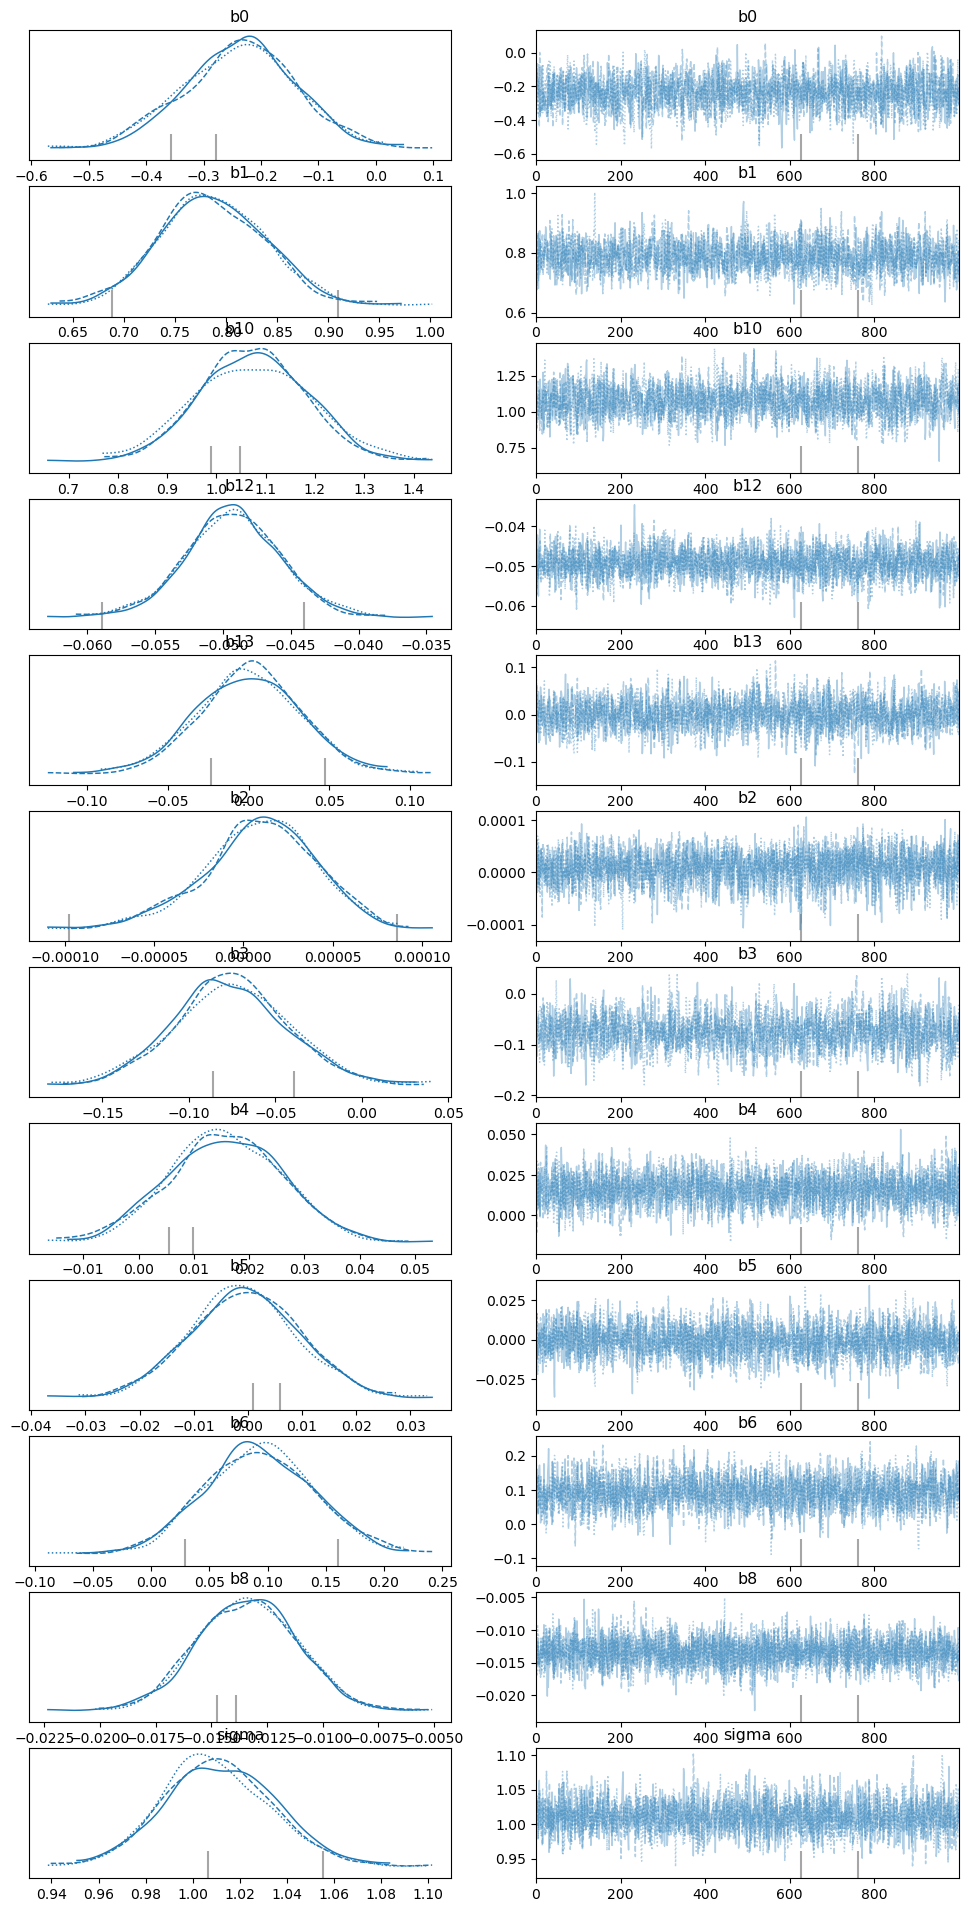

In [17]:
result = az.from_numpyro(mcmc)
DISPLAY_PARAMS = [p for p in result.to_dict()['posterior'].keys() if p != 'dg_pred']
az.plot_trace(result, var_names=DISPLAY_PARAMS);

In [33]:
samples = mcmc.get_samples()
posterior = numpyro.infer.Predictive(dg_model, posterior_samples=samples)

rng_key, rng_key_ = random.split(rng_key)
sorted_data = to_model.sort_values(by=['DG_OBS'])
post_pred = posterior(rng_key, 
          X=tuple(sorted_data[col].values for col in MODEL_COVARS),
          num_steps=10,
          y=None)

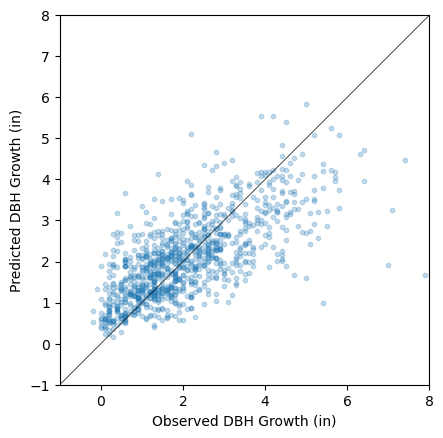

In [35]:
fig, ax = plt.subplots()
ax.scatter(sorted_data['DG_OBS'].values, post_pred['obs'].mean(axis=0), s=10.0, alpha=0.25)
ax.plot([-1,8], [-1,8], color='black', lw=0.5)
ax.set(ylim=(-1,8), xlim=(-1,8), aspect='equal', 
       xlabel='Observed DBH Growth (in)', ylabel='Predicted DBH Growth (in)')
plt.show()

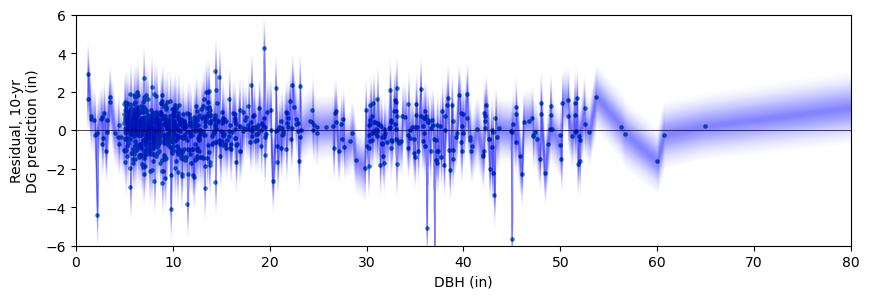

In [36]:
fig, ax = plt.subplots(figsize=(10,3))

d_sort = sorted_data.reset_index(drop=True).sort_values(by=['DBH']).index.values
resid = post_pred['obs'][:,d_sort] - sorted_data['DG_OBS'].values[d_sort]
ax.scatter(sorted_data['DBH'].values[d_sort], resid.mean(axis=0), s=5.5, alpha=0.8)
qs = np.quantile(resid, q=np.arange(5,96)/100., axis=0)
for q in range(45):
    ax.fill_between(sorted_data['DBH'].values[d_sort], y1=qs[(0+q)], y2=qs[-(1+q)], color='blue', alpha=0.01)
ax.axhline(0, lw=0.5, color='black')
ax.set(ylim=(-6,6), xlim=(0,80),
      xlabel='DBH (in)', ylabel='Residual, 10-yr\nDG prediction (in)')
plt.show()

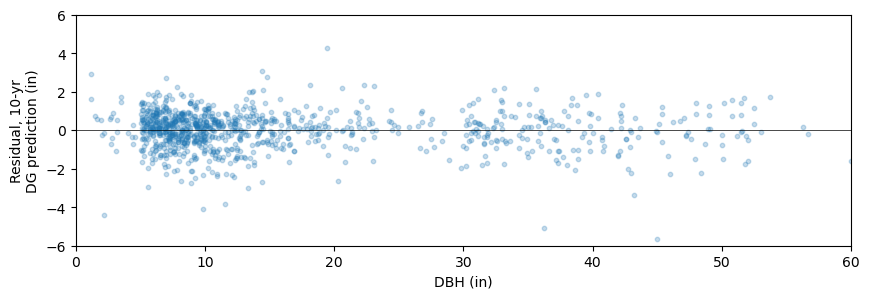

In [38]:
fig, ax = plt.subplots(figsize=(10,3))
d_sort = sorted_data.reset_index(drop=True).sort_values(by=['DBH']).index.values
resid = post_pred['obs'][:,d_sort] - sorted_data['DG_OBS'].values[d_sort]
ax.scatter(sorted_data['DBH'].values[d_sort], resid.mean(axis=0), s=10.0, alpha=0.25)
ax.axhline(0, lw=0.5, color='black')
ax.set(ylim=(-6,6), xlim=(0,60),
       xlabel='DBH (in)', ylabel='Residual, 10-yr\nDG prediction (in)'
      )
plt.show()

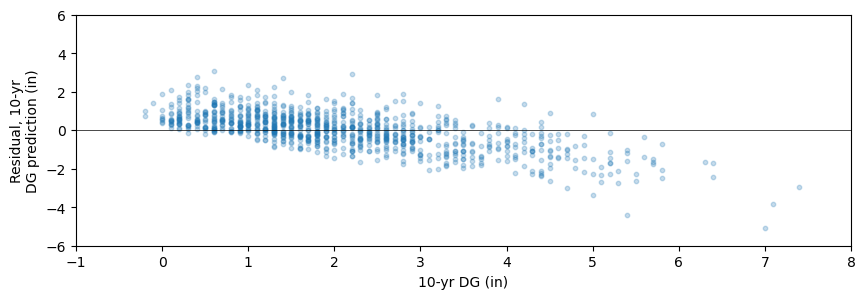

In [39]:
fig, ax = plt.subplots(figsize=(10,3))
resid = post_pred['obs'] - sorted_data['DG_OBS'].values
ax.scatter(sorted_data['DG_OBS'].values, resid.mean(axis=0), s=10.0, alpha=0.25)
ax.axhline(0, lw=0.5, color='black')
ax.set(ylim=(-6,6), xlim=(-1,8),
       xlabel='10-yr DG (in)', ylabel='Residual, 10-yr\nDG prediction (in)'
      )
plt.show()